### Libraries

In [804]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time
import sys
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import Image
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
import matplotlib.colors as colors
from sklearn.manifold import TSNE
import tensorflow as tf
from nltk import word_tokenize
import nltk
nltk.download('punkt')
from tf_slim.layers import layers as _layers
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, Input, Dense, LSTM, Embedding
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import classification_report,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /Users/Ali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv('Data/amazon_reviews_us_Electronics_v1_00.tsv.gz', sep='\t', error_bad_lines=False)

b'Skipping line 9076: expected 15 fields, saw 22\nSkipping line 19256: expected 15 fields, saw 22\nSkipping line 24313: expected 15 fields, saw 22\nSkipping line 47211: expected 15 fields, saw 22\nSkipping line 54295: expected 15 fields, saw 22\nSkipping line 56641: expected 15 fields, saw 22\nSkipping line 63067: expected 15 fields, saw 22\n'
b'Skipping line 93796: expected 15 fields, saw 22\n'
b'Skipping line 132806: expected 15 fields, saw 22\nSkipping line 164631: expected 15 fields, saw 22\nSkipping line 167019: expected 15 fields, saw 22\nSkipping line 167212: expected 15 fields, saw 22\n'
b'Skipping line 198103: expected 15 fields, saw 22\nSkipping line 199191: expected 15 fields, saw 22\nSkipping line 202841: expected 15 fields, saw 22\nSkipping line 218228: expected 15 fields, saw 22\nSkipping line 235900: expected 15 fields, saw 22\n'
b'Skipping line 277761: expected 15 fields, saw 22\nSkipping line 304582: expected 15 fields, saw 22\nSkipping line 312029: expected 15 fields,

In [4]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


DATA COLUMNS:

marketplace       - 2 letter country code of the marketplace where the review was written.

customer_id       - Random identifier that can be used to aggregate reviews written by a single author.

review_id         - The unique ID of the review.

product_id        - The unique Product ID the review pertains to. In the multilingual dataset the reviews
                    for the same product in different countries can be grouped by the same product_id.
                    
product_parent    - Random identifier that can be used to aggregate reviews for the same product.

product_title     - Title of the product.

product_category  - Broad product category that can be used to group reviews 
                    (also used to group the dataset into coherent parts).
                    
star_rating       - The 1-5 star rating of the review.

helpful_votes     - Number of helpful votes.

total_votes       - Number of total votes the review received.

vine              - Review was written as part of the Vine program.

verified_purchase - The review is on a verified purchase.

review_headline   - The title of the review.

review_body       - The review text.

review_date       - The date the review was written.


### Data Cleaning

In [5]:
#shape of the dataframe (3 million rows and 15 columns)
df.shape

(3091024, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3091024 entries, 0 to 3091023
Data columns (total 15 columns):
marketplace          object
customer_id          int64
review_id            object
product_id           object
product_parent       int64
product_title        object
product_category     object
star_rating          int64
helpful_votes        int64
total_votes          int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtypes: int64(5), object(10)
memory usage: 353.7+ MB


In [7]:
#to check if there is any null value in our dataframe
df.isna().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         4
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
review_headline      31
review_body          88
review_date          24
dtype: int64

In [8]:
#drop null values 
df.dropna(inplace=True)

In [9]:
#reviews of people who bought the product and have an opinion about it matters the most
df.verified_purchase.value_counts()

Y    2597511
N     493366
Name: verified_purchase, dtype: int64

In [10]:
#drop those reviews who didn't buy the product
df1 = df[df.verified_purchase != 'N']

In [11]:
#now our datafarmae only has contains reviews of people that bought the product
df1.verified_purchase.value_counts()

Y    2597511
Name: verified_purchase, dtype: int64

In [12]:
#check the class imbalance
df1.star_rating.value_counts()

5    1540908
4     443627
1     276682
3     195640
2     140654
Name: star_rating, dtype: int64

In [13]:
#show the name of the columns
df1.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

In [14]:
# Create a new dataframe and drop all the columns that we are not going to use them
df2 = df1.drop(columns=['marketplace','customer_id','review_id','product_id','product_parent','product_category',
                       'helpful_votes','total_votes','vine','review_date','verified_purchase'])

In [15]:
df2.head()

,product_title,star_rating,review_headline,review_body
0,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,5,Five Stars,As described.
1,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",5,It works as advertising.,It works as advertising.
2,Channel Master Titan 2 Antenna Preamplifier,5,Five Stars,Works pissa
3,LIMTECH Wall charger + USB Hotsync & Charging ...,1,One Star,Did not work at all.
4,Skullcandy Air Raid Portable Bluetooth Speaker,5,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...


In [16]:
#create DFs of each class
df_class1 = df2[df2.star_rating == 1]
df_class2 = df2[df2.star_rating == 2]
df_class3 = df2[df2.star_rating == 3]
df_class4 = df2[df2.star_rating == 4]
df_class5 = df2[df2.star_rating == 5]

In [17]:
#sample the data of star rating of 5 and 4, because more than 70% of the reviews belong to label 5
df_class5 = df_class5.sample(n=200000, random_state=52)
df_class4 = df_class4.sample(n=200000, random_state=52)

In [18]:
#concatinate the dataframes
df3 = pd.concat([df_class1, df_class2,df_class3,df_class4,df_class5], ignore_index=True)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012976 entries, 0 to 1012975
Data columns (total 4 columns):
product_title      1012976 non-null object
star_rating        1012976 non-null int64
review_headline    1012976 non-null object
review_body        1012976 non-null object
dtypes: int64(1), object(3)
memory usage: 30.9+ MB


In [19]:
#check the class imbalance
df3.star_rating.value_counts()

1    276682
5    200000
4    200000
3    195640
2    140654
Name: star_rating, dtype: int64

In [20]:
#shuffle the dataframe,  so all labels wouldn't be in order.
df4 = df3.sample(frac=1).reset_index(drop=True)
df4.head()

,product_title,star_rating,review_headline,review_body
0,Aurum Ultra Series - High Speed Micro HDMI to ...,2,Two Stars,Not the right size !
1,CR2032 Maxell LITHIUM 5 BATTERIES,5,Work exactly as they should,They come in a blister pack of 5 batteries. T...
2,XBMC KEY. (GOTHAM EDITION) Install Xbmc and 10...,1,"never again, hard too set up..","never again,hard too set up.."
3,Timex TX5020 LCD Electronic Indoor and Outdoor...,2,OK if you're lucky,I bought two units and place them side by side...
4,BlueRigger DVI Male to DVI Male Digital Dual-L...,5,Perfect cable,This cable is exactly what I needed. They are ...


In [52]:
#feature engineering a column that shows the feeling of the review (emotion)
def emotion(row):
    if row.star_rating == 1 or row.star_rating == 2:
        y = 'Negative'
    elif row.star_rating == 4 or row.star_rating == 5:
        y = 'Positive'
    else:
        y = "Neutral"
    return y       

In [22]:
#create the new column on the fly
df4['emotion'] = df4.apply(lambda row: emotion(row), axis=1)

In [23]:
df4.head()

,product_title,star_rating,review_headline,review_body,emotion
0,Aurum Ultra Series - High Speed Micro HDMI to ...,2,Two Stars,Not the right size !,Negative
1,CR2032 Maxell LITHIUM 5 BATTERIES,5,Work exactly as they should,They come in a blister pack of 5 batteries. T...,Positive
2,XBMC KEY. (GOTHAM EDITION) Install Xbmc and 10...,1,"never again, hard too set up..","never again,hard too set up..",Negative
3,Timex TX5020 LCD Electronic Indoor and Outdoor...,2,OK if you're lucky,I bought two units and place them side by side...,Negative
4,BlueRigger DVI Male to DVI Male Digital Dual-L...,5,Perfect cable,This cable is exactly what I needed. They are ...,Positive


#### Text Cleaning

In [24]:
#define a function to remove special characters, make all letters lower, and remove additional spaces
def text_cleaner(sentence):
    sentence = sentence.lower()
    cleaner = re.compile('[^a-z]')
    cleantext = re.sub(cleaner, ' ', sentence)
    cleaner1 = re.compile('\s+')
    cleantext2 = re.sub(cleaner1, ' ', cleantext)
    return cleantext2

In [25]:
df4['clean_review'] = df4['review_body'].map(lambda s:text_cleaner(s))

In [26]:
df4.tail(5)

,product_title,star_rating,review_headline,review_body,emotion,clean_review
1012971,Spinning Remote Control Organizer with Picture...,3,Much smaller,It is much smaller than what I thought...not w...,Neutral,it is much smaller than what i thought not wor...
1012972,Esky 1080P HD Ready Directional HDTV DTV Ampli...,2,Two Stars,Did not receive any extra channels when compar...,Negative,did not receive any extra channels when compar...
1012973,Clip Plus 4 GB MP3 Player (Black),2,Worked well for awhile,Stopped working all together after about 90 da...,Negative,stopped working all together after about days ...
1012974,12 Pack of 3.7V 5000mAH 18650 Rechargeable Li-...,3,OUT OF JUICE !!,Horrible batteries. ....dont hold a charge con...,Neutral,horrible batteries dont hold a charge constant...
1012975,Sennheiser Sports Earbud Headphones,1,Aweful sports band,These were the worst earphones i have ever bou...,Negative,these were the worst earphones i have ever bou...


In [48]:
df5 = df4.copy()

In [49]:
df5.drop(columns=['product_title', 'review_headline'], axis=1, inplace=True)

In [53]:
#feature engineering a column that shows the feeling of the review (emotion)
def emotion_1(row):
    if row.star_rating == 1 or row.star_rating == 2:
        y = 'Negative'
    else:
        y = 'Not Negative'
    
    return y    

In [54]:
#create the new column on the fly
df5['emotion'] = df5.apply(lambda row: emotion_1(row), axis=1)

In [55]:
df5.head()

,star_rating,review_body,emotion,clean_review
0,2,Not the right size !,Negative,not the right size
1,5,They come in a blister pack of 5 batteries. T...,Not Negative,they come in a blister pack of batteries the u...
2,1,"never again,hard too set up..",Negative,never again hard too set up
3,2,I bought two units and place them side by side...,Negative,i bought two units and place them side by side...
4,5,This cable is exactly what I needed. They are ...,Not Negative,this cable is exactly what i needed they are c...


In [895]:
len(df5)

1012976

In [513]:
df5.emotion.value_counts()

Not Negative    595640
Negative        417336
Name: emotion, dtype: int64

### EDA

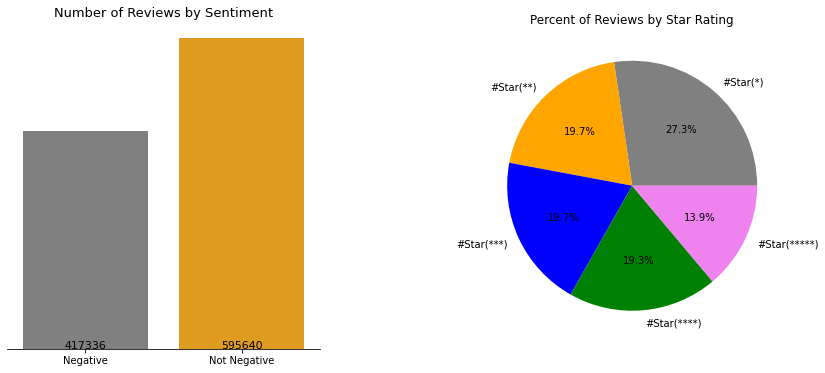

In [806]:

plt.figure(figsize = (14, 6))   

ax0 = plt.subplot(1, 2, 1)
ax1 = plt.subplot(1, 2, 2)

proportion = df5['star_rating'].value_counts()/df5.shape[0]
negative = len(df5[df5['emotion'] == 'Negative'])
not_negative = len(df5[df5['emotion'] == 'Not Negative'])
# No = len(df_classes[df_classes['classes'] == 'No'])
# Pituitary = len(df_classes[df_classes['classes'] == 'Pituitary'])

sns.countplot(x = 'emotion', data = df5, 
              palette = ['grey', 'orange'], ax = ax0)
ax0.set_title('Number of Reviews by Sentiment', size = 13)
ax0.set_xlabel(None)
ax0.text(x = 0, y = 100, s = negative, size = 11, 
         color = 'black', horizontalalignment = 'center')
ax0.text(x = 1, y = 100, s = not_negative, size = 11,
        color = 'black', horizontalalignment = 'center')
# ax0.text(x = 2, y = 100, s = No, size = 11,
#         color = 'black', horizontalalignment = 'center')
# ax0.text(x = 3, y = 100, s = Pituitary, size = 11,
#         color = 'white', horizontalalignment = 'center')
ax0.yaxis.set_visible(False)
sns.despine(left = True)

proportion.plot(kind = 'pie', autopct = '%.1f%%', 
                explode = [0, 0, 0, 0, 0], shadow = False,
                labels = ['#Star(*)', '#Star(**)', '#Star(***)', '#Star(****)','#Star(*****)'],
                colors = ['grey','orange', 'blue' , 'green', 'violet'], 
                ax = ax1)
ax1.set_title('Percent of Reviews by Star Rating')
ax1.yaxis.set_visible(False)

plt.subplots_adjust(wspace = 0.5)
plt.show()

In [58]:
#an example of a review
df5.clean_review[12]

'it is a waste of money go for higher models this model hiss and noise level makes useless i own for a long time now but hardly use it due to hiss '

In [59]:
df5.emotion[12]

'Negative'

In [65]:
def pretty_print_review_label(i):
    print(df5.emotion[i] + " \t : \t " + df5.clean_review[i][:80] + "...")

In [66]:
# How could I take this dataset and validate my theory that words are predictive of labels.
print("Labels \t\t : \t Review\n")
pretty_print_review_label(100)
pretty_print_review_label(1000)
pretty_print_review_label(10000)
pretty_print_review_label(100000)
pretty_print_review_label(1000003)

Labels 		 : 	 Review

Not Negative 	 : 	 fits onto our tv perfectly without adapters great sound easy to use my husband c...
Negative 	 : 	 my computer did not recognize this product and from reading the other reviews on...
Not Negative 	 : 	 they work ok br sound is ok br everything is ok no bad no good just ok br built ...
Not Negative 	 : 	 this is a gift to be given at the end of sept so it has not been opened as yet i...
Negative 	 : 	 i m a bit disappointed in the product love the bose but after reading and re rea...


In [514]:
#Count acts a lot like a dictionary, but they actually don't create the key, so they are much faster
not_negative_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

In [515]:
for i in range(len(df5)):
    if (df5.emotion[i] == 'Not Negative'):
        for word in df5.clean_review[i].split(" "): #to count every positive word in a positive review
            not_negative_counts[word] += 1
            total_counts[word] += 1
    
    else:
        for word in df5.clean_review[i].split(" "):
            negative_counts[word] += 1
            total_counts[word] += 1

In [516]:
#Total number of words
len(total_counts)

142478

In [517]:
len(negative_counts)

88320

In [518]:
len(not_negative_counts)

107568

In [519]:
not_negative_counts.most_common()[:20]

[('the', 2041740),
 ('i', 1295467),
 ('to', 1048563),
 ('and', 963422),
 ('it', 937281),
 ('a', 911067),
 ('is', 608193),
 ('for', 547863),
 ('', 496550),
 ('of', 490949),
 ('this', 433306),
 ('my', 427968),
 ('br', 410187),
 ('in', 400225),
 ('that', 392504),
 ('with', 359105),
 ('but', 358952),
 ('on', 325832),
 ('you', 322606),
 ('not', 304675)]

In [520]:
negative_counts.most_common()[:20]

[('the', 1381085),
 ('i', 964436),
 ('to', 714286),
 ('it', 712934),
 ('and', 639897),
 ('a', 587627),
 ('of', 357742),
 ('this', 350962),
 ('', 350124),
 ('not', 343817),
 ('is', 334288),
 ('for', 312655),
 ('in', 268851),
 ('my', 266477),
 ('that', 258386),
 ('br', 252823),
 ('was', 250122),
 ('t', 237871),
 ('on', 231259),
 ('but', 222247)]

* we are not really intersted in the most frequent positive words, we are interested in words that are most frequently positive versus negative.

* we want to come up with some sort of ratio that is more comparative between these two lists

In [521]:
#because most of the most common words in positive and negative lists are almost the same, making a ratio would solve
#the issue
pos_neg_ratios = Counter()

for term,cnt in list(total_counts.most_common()):
    if(cnt>200):
        pos_neg_ratio = not_negative_counts[term] / float(negative_counts[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio

In [524]:
#Make it even better
for word, ratio in list(pos_neg_ratios.most_common()):
    if(ratio > 1):
        pos_neg_ratios[word] = np.log(ratio)
    else:
        pos_neg_ratios[word] = -np.log((1/(ratio+0.01)))
      

In [525]:
#words frequently seen in a review with a 'Positive' label
pos_neg_ratios.most_common()[:20]

[('excelente', 3.290886360844473),
 ('excelent', 2.9980024220885304),
 ('loves', 2.50294757455331),
 ('pleasantly', 2.4287120914443583),
 ('blends', 2.3789073605536792),
 ('fills', 2.367123614131617),
 ('downside', 2.3454766576233586),
 ('frills', 2.313884648247979),
 ('drawback', 2.2936785521778424),
 ('exceeded', 2.2767643933723027),
 ('regrets', 2.1757183721152558),
 ('compliments', 2.047006265926682),
 ('unobtrusive', 2.038433517952459),
 ('bonus', 2.0270212557278913),
 ('caveats', 2.0074680420547466),
 ('unbeatable', 2.0045936508834035),
 ('soundstage', 2.0043209112117277),
 ('suits', 2.000916778567525),
 ('versatility', 1.9996355484114763),
 ('beat', 1.9957974411822226)]

In [526]:
#words frequently seen in a review with a 'Negative' label
list(reversed(pos_neg_ratios.most_common()))[:20]

[('fraud', -2.861729294030844),
 ('wast', -2.5939416535313415),
 ('waste', -2.3469097180655027),
 ('junk', -2.3440774616522004),
 ('scam', -2.2233088038017814),
 ('garbage', -2.0995027322203055),
 ('paperweight', -2.088802204039861),
 ('pos', -2.0616082683420447),
 ('recourse', -1.9790162612087407),
 ('refunds', -1.9329888089478),
 ('returnable', -1.8921938665498255),
 ('ashamed', -1.8782515005814986),
 ('trash', -1.8630385921927592),
 ('unsatisfied', -1.850624740427249),
 ('refund', -1.837381733677251),
 ('disgusted', -1.8045684275206362),
 ('restocking', -1.7707671917469574),
 ('wasted', -1.7392181921997867),
 ('utter', -1.7301389022485536),
 ('deadline', -1.70073654143535)]

## Design a Neural Network

In [80]:
#Create input/output data
#Count all the words that happende in our review
vocab = set(total_counts.keys())
vocab_size = len(vocab)
print(vocab_size)

142478


In [171]:
#put the vocab_size into a fixed length vector where each place in the vector belongs to one word of our vocabulary
#vector is empty and we edit it as we go forward
#I did this for memory efficiency, so we dont have to create a vector from scrath every time when we want to use it
#we also don't want to pregenerate data from the entire dataset, because that would be a matrix of 
# vocab_size * len(df4) = 144326794528 !!!!
layer_0 = np.zeros((1, vocab_size))
layer_0

array([[0., 0., 0., ..., 0., 0., 0.]])

In [172]:
word2index = {}

for i,word in enumerate(vocab):
    word2index[word] = i

In [190]:
def update_input_layer(review):
    
    global layer_0
    
    #clear out previous state, reset the layer to be all 0s
    layer_0 *= 0
    for word in review.split(" "):#iterate through each word
        layer_0[0][word2index[word]] += 1  # allocate a position in the vector by incrementing
        
update_input_layer(df5.clean_review[18])

In [191]:
layer_0[0]

array([1., 0., 0., ..., 0., 0., 0.])

In [192]:
np.max(layer_0)

13.0

In [88]:
#Create a function to get the label 
def get_target_for_label(label):
        if (label == 'Not Negative'):
            return 1
        else:
            return 0

In [89]:
df5.emotion[1]

'Not Negative'

In [90]:
get_target_for_label(df5.emotion[1])

1

#### Train Test Split

In [97]:
# Split the data by using clean reviews
y = df5['emotion']
X = df5['clean_review']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state= 52)

In [149]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [208]:
# Split the data by using default reviews
y = df5['emotion']
X = df5['review_body']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y,test_size=0.20, random_state= 52)

In [209]:
X_train1.reset_index(inplace=True, drop=True)
X_test1.reset_index(inplace=True, drop=True)
y_train1.reset_index(inplace=True, drop=True)
y_test1.reset_index(inplace=True, drop=True)

* Create our neural network
* 3 layer neural network
* no non-linearity in hidden layer
* use our functions to create the training data
* create a "pre_process_data" function to create vocabulary for our data generating functions
* modify "train" to train over the entire corpus

In [164]:
#create a network by using counts of words in our review, to predict the sentiment of our review
class SentimentNetwork:
    def __init__(self, reviews, labels, hidden_nodes=10, learning_rate=0.1):
        #set our random number generator
        np.random.seed(52)
        
        self.pre_process_data(reviews, labels)
        
        self.init_network(len(self.review_vocab), hidden_nodes, 1, learning_rate)
        
    def pre_process_data(self, reviews, labels):
        
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                review_vocab.add(word)
        self.review_vocab = list(review_vocab)
        
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        self.label_vocab = list(label_vocab)
        
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
            
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i
            
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        #set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        #initialize weights
        self.weights_0_1 = np.zeros((self.input_nodes, self.hidden_nodes))
        
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5,
                                           (self.hidden_nodes, self.output_nodes))
        self.learning_rate = learning_rate
        
        self.layer_0 = np.zeros((1, input_nodes))
        
    def update_input_layer(self, review):
        
        #clear out previous state, reset the layer to be all 0s
        self.layer_0 *= 0
        for word in review.split(" "):
            if(word in self.word2index.keys()):
                self.layer_0[0][self.word2index[word]] += 1
                
    def get_target_for_label(self, label):
        if (label == 'Not Negative'):
            return 1
        else:
            return 0
        
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self, output):
        return output * (1 - output)
    
    
    def train(self, training_reviews, training_labels):
        
        assert(len(training_reviews) == len(training_labels))
        
        #how the neural net is doing during the training process
        correct_so_far = 0
        
        start = time.time()
        
        for i in range(len(training_reviews)):
            
            review = training_reviews[i]
            label = training_labels[i]
            
            #implement the forward propagation here
            #forward pass
            
            #input layer
            self.update_input_layer(review)
            
            #Hidden layer
            layer_1 = self.layer_0.dot(self.weights_0_1)
            
            #Output layer
            layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))
            
            #implement the backward propagation here
            #Backward pass
            
            #Output error
            layer_2_error = layer_2 - self.get_target_for_label(label)
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)
            
            #backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) #errors propagated to the hidden layer
            layer_1_delta = layer_1_error #hidden layer gradients - no nonlinearity so it's the same as the error
            
            #update the weights
            self.weights_1_2 -= layer_1.T.dot(layer_2_delta) * self.learning_rate #Update hidden-to-output weights
            self.weights_0_1 -= self.layer_0.T.dot(layer_1_delta) * self.learning_rate #update input-to-hidden weights
            
            if(np.abs(layer_2_error) < 0.5):
                correct_so_far += 1
                
            reviews_per_second = i / float(time.time() - start)
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] 
                              + "% speed(reviews/sec):" + str(reviews_per_second)[0:5]
                        + " #Correct: " + str(correct_so_far) + " #Trained:" + str(i+1) + " Training Accuracy:" +
                         str(100 * correct_so_far/ (i+1))[:4] + "%")
        
            if(i % 100000 == 0):
                print("")
                
    #defining this function if I want to run it on a dataset            
    def test(self, testing_reviews, testing_labels):
        correct = 0
        start = time.time()
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
                
        reviews_per_second = i / float(time.time() - start)
        
        sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] 
                             + "% speed(reviews/sec):" + str(reviews_per_second)[0:5]
                        + " #Correct: " + str(correct) + " #Tested:" + str(i+1) + " Testing Accuracy:" +
                         str(100 * correct/ len(testing_reviews))[:4] + "%")
        
    #defining this function if I want to run it on a single review    
    def run(self, review):
        #Input layer
        self.update_input_layer(review)
        
        #Hidden layer
        layer_1 = self.layer_0.dot(self.weights_0_1)
        
        #Output layer
        layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))
        
        if(layer_2[0] > 0.5):
            return "Not Negative"
        else:
            return "Negative"
            

In [165]:
# Initialize the model
mlp = SentimentNetwork(X_train, y_train, learning_rate=0.1)

In [160]:
#evaluate my model before training (just to show how horrible it is)
#because our weights are initialized randomely, so it shouldn't really predict well at all
#it also shows that the model is not biased
mlp.test(X_test, y_test)

Progress:99.9% speed(reviews/sec):1178. #Correct: 83671 #Tested:202596 Testing Accuracy:41.2%

In [166]:
mlp.train(X_train, y_train)

Progress:0.0% speed(reviews/sec):0.0 #Correct: 0 #Trained:1 Training Accuracy:0.0%
Progress:12.3% speed(reviews/sec):133.4 #Correct: 80654 #Trained:100001 Training Accuracy:9.95%
Progress:24.6% speed(reviews/sec):131.9 #Correct: 163503 #Trained:200001 Training Accuracy:20.1%
Progress:37.0% speed(reviews/sec):132.4 #Correct: 246654 #Trained:300001 Training Accuracy:30.4%
Progress:49.3% speed(reviews/sec):132.7 #Correct: 329995 #Trained:400001 Training Accuracy:40.7%
Progress:61.6% speed(reviews/sec):132.6 #Correct: 413661 #Trained:500001 Training Accuracy:51.0%
Progress:74.0% speed(reviews/sec):133.1 #Correct: 497573 #Trained:600001 Training Accuracy:61.3%
Progress:86.3% speed(reviews/sec):133.5 #Correct: 581557 #Trained:700001 Training Accuracy:71.7%
Progress:98.7% speed(reviews/sec):133.8 #Correct: 665484 #Trained:800001 Training Accuracy:82.1%
Progress:99.9% speed(reviews/sec):133.8 #Correct: 674112 #Trained:810380 Training Accuracy:83.1%

In [167]:
mlp = SentimentNetwork(X_train, y_train, learning_rate=0.01)

In [168]:
mlp.train(X_train, y_train)

Progress:0.0% speed(reviews/sec):0.0 #Correct: 0 #Trained:1 Training Accuracy:0.0%
Progress:12.3% speed(reviews/sec):167.0 #Correct: 80515 #Trained:100001 Training Accuracy:9.93%
Progress:24.6% speed(reviews/sec):166.8 #Correct: 163311 #Trained:200001 Training Accuracy:20.1%
Progress:37.0% speed(reviews/sec):166.7 #Correct: 246461 #Trained:300001 Training Accuracy:30.4%
Progress:49.3% speed(reviews/sec):166.6 #Correct: 329835 #Trained:400001 Training Accuracy:40.7%
Progress:61.6% speed(reviews/sec):166.6 #Correct: 413542 #Trained:500001 Training Accuracy:51.0%
Progress:74.0% speed(reviews/sec):166.6 #Correct: 497532 #Trained:600001 Training Accuracy:61.3%
Progress:86.3% speed(reviews/sec):166.6 #Correct: 581554 #Trained:700001 Training Accuracy:71.7%
Progress:98.7% speed(reviews/sec):166.5 #Correct: 665499 #Trained:800001 Training Accuracy:82.1%
Progress:99.9% speed(reviews/sec):166.5 #Correct: 674121 #Trained:810380 Training Accuracy:83.1%

In [169]:
mlp = SentimentNetwork(X_train, y_train, learning_rate=0.001)

In [170]:
mlp.train(X_train, y_train)

Progress:0.0% speed(reviews/sec):0.0 #Correct: 0 #Trained:1 Training Accuracy:0.0%
Progress:12.3% speed(reviews/sec):162.1 #Correct: 79811 #Trained:100001 Training Accuracy:9.84%
Progress:24.6% speed(reviews/sec):161.9 #Correct: 162295 #Trained:200001 Training Accuracy:20.0%
Progress:37.0% speed(reviews/sec):162.0 #Correct: 245221 #Trained:300001 Training Accuracy:30.2%
Progress:49.3% speed(reviews/sec):162.0 #Correct: 328468 #Trained:400001 Training Accuracy:40.5%
Progress:61.6% speed(reviews/sec):162.0 #Correct: 412051 #Trained:500001 Training Accuracy:50.8%
Progress:74.0% speed(reviews/sec):162.0 #Correct: 495941 #Trained:600001 Training Accuracy:61.1%
Progress:86.3% speed(reviews/sec):162.0 #Correct: 579842 #Trained:700001 Training Accuracy:71.5%
Progress:98.7% speed(reviews/sec):162.1 #Correct: 663641 #Trained:800001 Training Accuracy:81.8%
Progress:99.9% speed(reviews/sec):162.1 #Correct: 672253 #Trained:810380 Training Accuracy:82.9%

### Reducing Noise in Our input Data

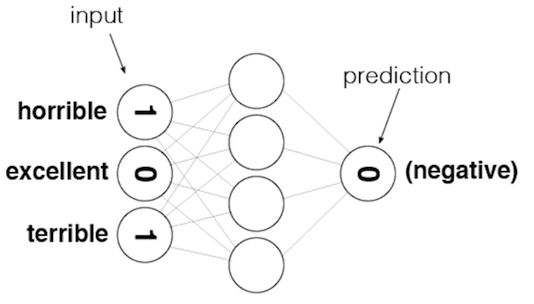

In [205]:
Image(filename='Images/sentiment_network.png')

The whole game is about noise versus signal

We know forward propagation is a weighted sum (actually weighted sum of weighted sums), so as we can see in the Image, 4 weights coming out of each neuron in input layer (i.e. '1' multulply by 4 and add together to form a vector)

How high the number of a neuron is affects how dominantly these weights control the hidden layer and these weights control how dominantly this input affects the hidden layer (funny that they are interpreted by each other!)

For instance, if `horrible` is going to multiply by 18 and `terrible` multiply by 1, then `horrible` is going to be a dominant word and the vectors in the hidden layer are gonna be exactly the same as these 4 weights of `horrible`

most of the words with higher frequencies are irrelevant words and have nothing to do with sentiment and their weighting is casing it to have a dominant effect on the hidden layer and hidden layer is all that output layer gets to use to make a prediction, so the hidden layer is not going to have rich information.

Maybe counting words is not a good idea, because the counts don't highlight the signal (when we look at the counts, it seems like we are looking at the noise). Therefore my idea is to instead of counts just represent each existing word in a review as 1 (not incrementing it).

In [216]:
#let's meet noise
not_negative_counts.most_common()[:20]

[('the', 2041740),
 ('i', 1295467),
 ('to', 1048563),
 ('and', 963422),
 ('it', 937281),
 ('a', 911067),
 ('is', 608193),
 ('for', 547863),
 ('', 496550),
 ('of', 490949),
 ('this', 433306),
 ('my', 427968),
 ('br', 410187),
 ('in', 400225),
 ('that', 392504),
 ('with', 359105),
 ('but', 358952),
 ('on', 325832),
 ('you', 322606),
 ('not', 304675)]

In [230]:
#create a network by using counts of words in our review, to predict the sentiment of our review
class SentimentNetwork:
    def __init__(self, reviews, labels, hidden_nodes=10, learning_rate=0.1):
        #set our random number generator
        np.random.seed(52)
        
        self.pre_process_data(reviews, labels)
        
        self.init_network(len(self.review_vocab), hidden_nodes, 1, learning_rate)
        
    def pre_process_data(self, reviews, labels):
        
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                review_vocab.add(word)
        self.review_vocab = list(review_vocab)
        
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        self.label_vocab = list(label_vocab)
        
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
            
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i
            
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        #set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        #initialize weights
        self.weights_0_1 = np.zeros((self.input_nodes, self.hidden_nodes))
        
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5,
                                           (self.hidden_nodes, self.output_nodes))
        self.learning_rate = learning_rate
        
        self.layer_0 = np.zeros((1, input_nodes))
        
    def update_input_layer(self, review):
        
        #clear out previous state, reset the layer to be all 0s
        self.layer_0 *= 0
        for word in review.split(" "):
            if(word in self.word2index.keys()):
                self.layer_0[0][self.word2index[word]] = 1
                
    def get_target_for_label(self, label):
        if (label == 'Not Negative'):
            return 1
        else:
            return 0
        
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self, output):
        return output * (1 - output)
    
    
    def train(self, training_reviews, training_labels):
        
        assert(len(training_reviews) == len(training_labels))
        
        #how the neural net is doing during the training process
        correct_so_far = 0
        
        start = time.time()
        
        for i in range(len(training_reviews)):
            
            review = training_reviews[i]
            label = training_labels[i]
            
            #implement the forward propagation here
            #forward pass
            
            #input layer
            self.update_input_layer(review)
            
            #Hidden layer
            layer_1 = self.layer_0.dot(self.weights_0_1)
            
            #Output layer
            layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))
            
            #implement the backward propagation here
            #Backward pass
            
            #Output error
            layer_2_error = layer_2 - self.get_target_for_label(label)
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)
            
            #backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) #errors propagated to the hidden layer
            layer_1_delta = layer_1_error #hidden layer gradients - no nonlinearity so it's the same as the error
            
            #update the weights
            self.weights_1_2 -= layer_1.T.dot(layer_2_delta) * self.learning_rate #Update hidden-to-output weights
            self.weights_0_1 -= self.layer_0.T.dot(layer_1_delta) * self.learning_rate #update input-to-hidden weights
            
            if(np.abs(layer_2_error) < 0.5):
                correct_so_far += 1
                
            reviews_per_second = i / float(time.time() - start)
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] 
                              + "% speed(reviews/sec):" + str(reviews_per_second)[0:5]
                        + " #Correct: " + str(correct_so_far) + " #Trained:" + str(i+1) + " Training Accuracy:" +
                         str(100 * correct_so_far/ (i+1))[:4] + "%")
        
            if(i % 100000 == 0):
                print("")
                
    #defining this function if I want to run it on a dataset            
    def test(self, testing_reviews, testing_labels):
        correct = 0
        start = time.time()
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
                
        reviews_per_second = i / float(time.time() - start)
        
        sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] 
                             + "% speed(reviews/sec):" + str(reviews_per_second)[0:5]
                        + " #Correct: " + str(correct) + " #Tested:" + str(i+1) + " Testing Accuracy:" +
                         str(100 * correct/ len(testing_reviews))[:4] + "%")
        
    #defining this function if I want to run it on a single review    
    def run(self, review):
        #Input layer
        self.update_input_layer(review)
        
        #Hidden layer
        layer_1 = self.layer_0.dot(self.weights_0_1)
        
        #Output layer
        layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))
        
        if(layer_2[0] > 0.5):
            return "Not Negative"
        else:
            return "Negative"
            

In [231]:
mlp = SentimentNetwork(X_train, y_train, learning_rate=0.1)

In [202]:
mlp.train(X_train,y_train)

Progress:0.0% speed(reviews/sec):0.0 #Correct: 0 #Trained:1 Training Accuracy:0.0%
Progress:12.3% speed(reviews/sec):132.8 #Correct: 81988 #Trained:100001 Training Accuracy:81.9%
Progress:24.6% speed(reviews/sec):133.5 #Correct: 165502 #Trained:200001 Training Accuracy:82.7%
Progress:37.0% speed(reviews/sec):133.1 #Correct: 249175 #Trained:300001 Training Accuracy:83.0%
Progress:49.3% speed(reviews/sec):133.1 #Correct: 332987 #Trained:400001 Training Accuracy:83.2%
Progress:61.6% speed(reviews/sec):132.8 #Correct: 417135 #Trained:500001 Training Accuracy:83.4%
Progress:74.0% speed(reviews/sec):133.2 #Correct: 501568 #Trained:600001 Training Accuracy:83.5%
Progress:86.3% speed(reviews/sec):133.7 #Correct: 585822 #Trained:700001 Training Accuracy:83.6%
Progress:98.7% speed(reviews/sec):133.9 #Correct: 670121 #Trained:800001 Training Accuracy:83.7%
Progress:99.9% speed(reviews/sec):133.8 #Correct: 678783 #Trained:810380 Training Accuracy:83.7%

* as we can see the model starts to learn much faster than before which is great!
* we eliminated a lot of our noise (by getting rid of weighted useless words)
* the model can find correlation between words so much faster (Accuracy of 80% in less than 1% of the whole data)
* we didn't eliminate stoping words, but the interesting point is that our model is capable to find the words that matter the most

In [206]:
mlp.test(X_test, y_test)

Progress:99.9% speed(reviews/sec):914.4 #Correct: 170750 #Tested:202596 Testing Accuracy:84.2%

In [213]:
mlp = SentimentNetwork(X_train1, y_train1, learning_rate=0.01)

In [214]:
mlp.train(X_train1,y_train1)

Progress:0.0% speed(reviews/sec):0.0 #Correct: 0 #Trained:1 Training Accuracy:0.0%
Progress:12.3% speed(reviews/sec):21.16 #Correct: 80722 #Trained:100001 Training Accuracy:80.7%
Progress:24.6% speed(reviews/sec):21.92 #Correct: 163444 #Trained:200001 Training Accuracy:81.7%
Progress:31.4% speed(reviews/sec):22.09 #Correct: 209066 #Trained:255124 Training Accuracy:81.9%

KeyboardInterrupt: 

as we can see training the model without cleaning would result in much slower model (22 reviews per second), without any improvement in training accuracy. (worth trying it)

### Analyzing Inefficiencies in our Network

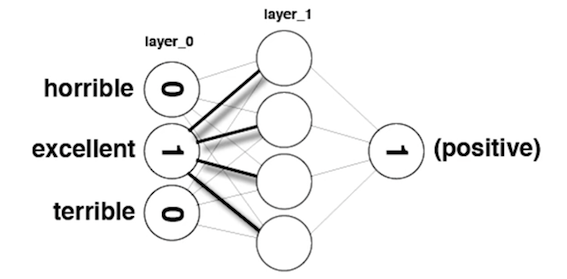

In [285]:
Image(filename='Images/sentiment_network_sparse.png')

we are creating a really big vector for layer_0 (1 x 142478) and only a small proportion of it would be 1 and a large number of them would be 0 in each review.
zero times anything is still a zero, all these zeros aren't doing anything. That to me is the biggest source of inefficiencies in this network.
On the other hand, one times anything is just itself. so, these 1 times weights is just kind of a waste.

In [280]:
#create a network by using counts of words in our review, to predict the sentiment of our review
class SentimentNetwork:
    def __init__(self, reviews, labels, hidden_nodes=10, learning_rate=0.1):
        #set our random number generator
        np.random.seed(52)
        
        self.pre_process_data(reviews, labels)
        
        self.init_network(len(self.review_vocab), hidden_nodes, 1, learning_rate)
        
    def pre_process_data(self, reviews, labels):
        
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                review_vocab.add(word)
        self.review_vocab = list(review_vocab)
        
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        self.label_vocab = list(label_vocab)
        
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
            
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i
            
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        #set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        #initialize weights
        self.weights_0_1 = np.zeros((self.input_nodes, self.hidden_nodes))
        
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5,
                                           (self.hidden_nodes, self.output_nodes))
        self.learning_rate = learning_rate
        
        self.layer_0 = np.zeros((1, input_nodes))
        self.layer_1 = np.zeros((1, hidden_nodes))
    def update_input_layer(self, review):
        
        #clear out previous state, reset the layer to be all 0s
        self.layer_0 *= 0
        for word in review.split(" "):
            if(word in self.word2index.keys()):
                self.layer_0[0][self.word2index[word]] = 1
                
    def get_target_for_label(self, label):
        if (label == 'Not Negative'):
            return 1
        else:
            return 0
        
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self, output):
        return output * (1 - output)
    
    
    def train(self, training_reviews_raw, training_labels):
        #added a preprocessing step into train mehtod
        #for each review we convert the words to the row of our word matrix that it corresponds to
        training_reviews = list()
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(" "):
                if(word in self.word2index.keys()):
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))
        
        assert(len(training_reviews) == len(training_labels))
        
        #how the neural net is doing during the training process
        correct_so_far = 0
        
        start = time.time()
        
        for i in range(len(training_reviews)):
            
            review = training_reviews[i]
            label = training_labels[i]
            
            #implement the forward propagation here
            #forward pass
            
            #input layer
            #based on a chunk of code that I added to the beggining of this function.
            #it allows me to completely skip the input layer and we jump straight to generate our hidden layer
            
            
            #Hidden layer
            #layer_1 = self.layer_0.dot(self.weights_0_1)
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]
            
            #Output layer
            layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
            
            #implement the backward propagation here
            #Backward pass
            
            #Output error
            layer_2_error = layer_2 - self.get_target_for_label(label)
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)
            
            #backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) #errors propagated to the hidden layer
            layer_1_delta = layer_1_error #hidden layer gradients - no nonlinearity so it's the same as the error
            
            #update the weights
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta)* self.learning_rate #Update hidden-to-output weights
            
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate #update input-to-hidden weights
            
            if(np.abs(layer_2_error) < 0.5):
                correct_so_far += 1
                
            reviews_per_second = i / float(time.time() - start)
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] 
                              + "% speed(reviews/sec):" + str(reviews_per_second)[0:5]
                        + " #Correct: " + str(correct_so_far) + " #Trained:" + str(i+1) + " Training Accuracy:" +
                         str(100 * correct_so_far/ (i+1))[:4] + "%")
        
            if(i % 100000 == 0):
                print("")
            sys.stdout.flush()    
    #defining this function if I want to run it on a dataset            
    def test(self, testing_reviews, testing_labels):
        correct = 0
        start = time.time()
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
                
        reviews_per_second = i / float(time.time() - start)
        
        sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] 
                             + "% speed(reviews/sec):" + str(reviews_per_second)[0:5]
                        + " #Correct: " + str(correct) + " #Tested:" + str(i+1) + " Testing Accuracy:" +
                         str(100 * correct/ len(testing_reviews))[:4] + "%")
        
    #defining this function if I want to run it on a single review    
    def run(self, review):
        #Input layer
        
        
        #Hidden layer
        self.layer_1 *= 0
        unique_indices =set()
        for word in review.split(" "):
            if word in self.word2index.keys():
                unique_indices.add(self.word2index[word])
        for index in unique_indices:
            self.layer_1 += self.weights_0_1[index]
        
        #Output layer
        layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
        
        if(layer_2[0] > 0.5):
            return "Not Negative"
        else:
            return "Negative"
            

In [281]:
mlp = SentimentNetwork(X_train, y_train, learning_rate=0.01)

In [282]:
mlp.train(X_train,y_train)

Progress:0.0% speed(reviews/sec):0.0 #Correct: 0 #Trained:1 Training Accuracy:0.0%
Progress:12.3% speed(reviews/sec):750.8 #Correct: 81948 #Trained:100001 Training Accuracy:81.9%
Progress:24.6% speed(reviews/sec):759.1 #Correct: 165367 #Trained:200001 Training Accuracy:82.6%
Progress:37.0% speed(reviews/sec):759.9 #Correct: 249069 #Trained:300001 Training Accuracy:83.0%
Progress:49.3% speed(reviews/sec):762.4 #Correct: 332888 #Trained:400001 Training Accuracy:83.2%
Progress:61.6% speed(reviews/sec):763.6 #Correct: 417057 #Trained:500001 Training Accuracy:83.4%
Progress:74.0% speed(reviews/sec):764.8 #Correct: 501499 #Trained:600001 Training Accuracy:83.5%
Progress:86.3% speed(reviews/sec):765.1 #Correct: 585780 #Trained:700001 Training Accuracy:83.6%
Progress:98.7% speed(reviews/sec):765.5 #Correct: 670089 #Trained:800001 Training Accuracy:83.7%
Progress:99.9% speed(reviews/sec):765.6 #Correct: 678758 #Trained:810380 Training Accuracy:83.7%

In [283]:
mlp.test(X_test,y_test)

Progress:99.9% speed(reviews/sec):6576. #Correct: 170819 #Tested:202596 Testing Accuracy:84.3%

### Further Noise Reduction

what we can do that our network really cut through the obvious stuff and focus on more complex stuff?
we can framing the problem so, the network would be as successful as possible.

In [527]:
#words frequently seen in a review with a 'Positive' label
pos_neg_ratios.most_common()[:20]

[('excelente', 3.290886360844473),
 ('excelent', 2.9980024220885304),
 ('loves', 2.50294757455331),
 ('pleasantly', 2.4287120914443583),
 ('blends', 2.3789073605536792),
 ('fills', 2.367123614131617),
 ('downside', 2.3454766576233586),
 ('frills', 2.313884648247979),
 ('drawback', 2.2936785521778424),
 ('exceeded', 2.2767643933723027),
 ('regrets', 2.1757183721152558),
 ('compliments', 2.047006265926682),
 ('unobtrusive', 2.038433517952459),
 ('bonus', 2.0270212557278913),
 ('caveats', 2.0074680420547466),
 ('unbeatable', 2.0045936508834035),
 ('soundstage', 2.0043209112117277),
 ('suits', 2.000916778567525),
 ('versatility', 1.9996355484114763),
 ('beat', 1.9957974411822226)]

In [528]:
#words frequently seen in a review with a 'Negative' label
list(reversed(pos_neg_ratios.most_common()))[:20]

[('fraud', -2.861729294030844),
 ('wast', -2.5939416535313415),
 ('waste', -2.3469097180655027),
 ('junk', -2.3440774616522004),
 ('scam', -2.2233088038017814),
 ('garbage', -2.0995027322203055),
 ('paperweight', -2.088802204039861),
 ('pos', -2.0616082683420447),
 ('recourse', -1.9790162612087407),
 ('refunds', -1.9329888089478),
 ('returnable', -1.8921938665498255),
 ('ashamed', -1.8782515005814986),
 ('trash', -1.8630385921927592),
 ('unsatisfied', -1.850624740427249),
 ('refund', -1.837381733677251),
 ('disgusted', -1.8045684275206362),
 ('restocking', -1.7707671917469574),
 ('wasted', -1.7392181921997867),
 ('utter', -1.7301389022485536),
 ('deadline', -1.70073654143535)]

In [292]:
output_notebook()

Loading BokehJS ...

In [529]:
hist, edges = np.histogram(list(map(lambda x:x[1],pos_neg_ratios.most_common())),density=True,bins=100,normed=True)

p = figure(tools='pan,wheel_zoom,reset,save',
          toolbar_location='above',
          title = 'word Not Negative/Negative Affinity Distribution')
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#777777")
show(p)

In [530]:
frequency_frequency = Counter()
for word, count in total_counts.most_common():
    frequency_frequency[count] += 1

In [531]:
hist, edges = np.histogram(list(map(lambda x:x[1],frequency_frequency.most_common())),
                           density=True,bins=100,normed=True)

p = figure(tools='pan,wheel_zoom,reset,save',
          toolbar_location='above',
          title = 'The Frequency Distribution of the words in our corpus')
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#777777")
show(p)

In [532]:
#create a network by using counts of words in our review, to predict the sentiment of our review
class SentimentNetwork:
    def __init__(self, reviews, labels,min_count=10,polarity_cutoff=0.1, hidden_nodes=10, learning_rate=0.1):
        #set our random number generator
        np.random.seed(52)
        
        self.pre_process_data(reviews,labels, polarity_cutoff, min_count)
        
        self.init_network(len(self.review_vocab), hidden_nodes, 1, learning_rate)
        
    def pre_process_data(self, reviews,labels, polarity_cutoff, min_count):
        
        not_negative_counts = Counter()
        negative_counts = Counter()
        total_counts = Counter()
        
        for i in range(len(reviews)):
            if (reviews[i] == 'Not Negative'):
                for word in reviews[i].split(" "): #to count every positive word in a positive review
                    not_negative_counts[word] += 1
                    total_counts[word] += 1
    
            else:
                for word in reviews[i].split(" "):
                    negative_counts[word] += 1
                    total_counts[word] += 1
            

        pos_neg_ratios = Counter()

        for term,cnt in list(total_counts.most_common()):
            if(cnt>200):
                pos_neg_ratio = not_negative_counts[term] / float(negative_counts[term]+1)
                pos_neg_ratios[term] = pos_neg_ratio

        #Make it even better
        for word, ratio in pos_neg_ratios.most_common():
            if(ratio > 1):
                pos_neg_ratios[word] = np.log(ratio)
            else:
                pos_neg_ratios[word] = -np.log((1/(ratio+0.01)))   
            
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                if(total_counts[word] > min_count):
                    if(word in pos_neg_ratios.keys()):
                        if((pos_neg_ratios[word] >= polarity_cutoff) or (pos_neg_ratios[word]<= -polarity_cutoff)):
                            review_vocab.add(word)
                    else:
                        review_vocab.add(word)
                
        self.review_vocab = list(review_vocab)
        
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        self.label_vocab = list(label_vocab)
        
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
            
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i
            
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        #set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        #initialize weights
        self.weights_0_1 = np.zeros((self.input_nodes, self.hidden_nodes))
        
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5,
                                           (self.hidden_nodes, self.output_nodes))
        self.learning_rate = learning_rate
        
        self.layer_0 = np.zeros((1, input_nodes))
        self.layer_1 = np.zeros((1, hidden_nodes))
    def update_input_layer(self, review):
        
        #clear out previous state, reset the layer to be all 0s
        self.layer_0 *= 0
        for word in review.split(" "):
            if(word in self.word2index.keys()):
                self.layer_0[0][self.word2index[word]] = 1
                
    def get_target_for_label(self, label):
        if (label == 'Not Negative'):
            return 1
        else:
            return 0
        
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self, output):
        return output * (1 - output)
    
    
    def train(self, training_reviews_raw, training_labels):
        #added a preprocessing step into train mehtod
        #for each review we convert the words to the row of our word matrix that it corresponds to
        training_reviews = list()
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(" "):
                if(word in self.word2index.keys()):
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))
        
        assert(len(training_reviews) == len(training_labels))
        
        #how the neural net is doing during the training process
        correct_so_far = 0
        
        start = time.time()
        
        for i in range(len(training_reviews)):
            
            review = training_reviews[i]
            label = training_labels[i]
            
            #implement the forward propagation here
            #forward pass
            
            #input layer
            #based on a chunk of code that I added to the beggining of this function.
            #it allows me to completely skip the input layer and we jump straight to generate our hidden layer
            
            
            #Hidden layer
            #layer_1 = self.layer_0.dot(self.weights_0_1)
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]
            
            #Output layer
            layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
            
            #implement the backward propagation here
            #Backward pass
            
            #Output error
            layer_2_error = layer_2 - self.get_target_for_label(label)
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)
            
            #backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) #errors propagated to the hidden layer
            layer_1_delta = layer_1_error #hidden layer gradients - no nonlinearity so it's the same as the error
            
            #update the weights
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta)* self.learning_rate #Update hidden-to-output weights
            
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate #update input-to-hidden weights
            
            if(np.abs(layer_2_error) < 0.5):
                correct_so_far += 1
                
            reviews_per_second = i / float(time.time() - start)
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] 
                              + "% speed(reviews/sec):" + str(reviews_per_second)[0:5]
                        + " #Correct: " + str(correct_so_far) + " #Trained:" + str(i+1) + " Training Accuracy:" +
                         str(100 * correct_so_far/ (i+1))[:4] + "%")
        
            if(i % 100000 == 0):
                print("")
            sys.stdout.flush()    
    #defining this function if I want to run it on a dataset            
    def test(self, testing_reviews, testing_labels):
        correct = 0
        start = time.time()
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
                
        reviews_per_second = i / float(time.time() - start)
        
        sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] 
                             + "% speed(reviews/sec):" + str(reviews_per_second)[0:5]
                        + " #Correct: " + str(correct) + " #Tested:" + str(i+1) + " Testing Accuracy:" +
                         str(100 * correct/ len(testing_reviews))[:4] + "%")
        
    #defining this function if I want to run it on a single review    
    def run(self, review):
        #Input layer
        
        
        #Hidden layer
        self.layer_1 *= 0
        unique_indices =set()
        for word in review.split(" "):
            if word in self.word2index.keys():
                unique_indices.add(self.word2index[word])
        for index in unique_indices:
            self.layer_1 += self.weights_0_1[index]
        
        #Output layer
        layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
        
        if(layer_2[0] > 0.5):
            return "Not Negative"
        else:
            return "Negative"
            

In [534]:
mlp = SentimentNetwork(X_train, y_train, learning_rate=0.01, min_count=40, polarity_cutoff=0.1)

In [535]:
mlp.train(X_train, y_train)

Progress:0.0% speed(reviews/sec):0.0 #Correct: 0 #Trained:1 Training Accuracy:0.0%
Progress:12.3% speed(reviews/sec):750.4 #Correct: 81939 #Trained:100001 Training Accuracy:81.9%
Progress:24.6% speed(reviews/sec):747.5 #Correct: 165335 #Trained:200001 Training Accuracy:82.6%
Progress:37.0% speed(reviews/sec):755.8 #Correct: 249014 #Trained:300001 Training Accuracy:83.0%
Progress:49.3% speed(reviews/sec):761.1 #Correct: 332810 #Trained:400001 Training Accuracy:83.2%
Progress:61.6% speed(reviews/sec):765.1 #Correct: 416950 #Trained:500001 Training Accuracy:83.3%
Progress:74.0% speed(reviews/sec):767.7 #Correct: 501365 #Trained:600001 Training Accuracy:83.5%
Progress:86.3% speed(reviews/sec):769.5 #Correct: 585614 #Trained:700001 Training Accuracy:83.6%
Progress:98.7% speed(reviews/sec):769.8 #Correct: 669880 #Trained:800001 Training Accuracy:83.7%
Progress:99.9% speed(reviews/sec):769.6 #Correct: 678546 #Trained:810380 Training Accuracy:83.7%

In [571]:
#going more aggressive and cutoff a bigger chunk of the words
mlp = SentimentNetwork(X_train, y_train, learning_rate=0.01, min_count=20, polarity_cutoff=0.5)

In [572]:
mlp.train(X_train, y_train)

Progress:0.0% speed(reviews/sec):0.0 #Correct: 0 #Trained:1 Training Accuracy:0.0%
Progress:12.3% speed(reviews/sec):612.7 #Correct: 81943 #Trained:100001 Training Accuracy:81.9%
Progress:24.6% speed(reviews/sec):652.9 #Correct: 165346 #Trained:200001 Training Accuracy:82.6%
Progress:37.0% speed(reviews/sec):693.3 #Correct: 249033 #Trained:300001 Training Accuracy:83.0%
Progress:49.3% speed(reviews/sec):709.4 #Correct: 332838 #Trained:400001 Training Accuracy:83.2%
Progress:61.6% speed(reviews/sec):730.8 #Correct: 416992 #Trained:500001 Training Accuracy:83.3%
Progress:74.0% speed(reviews/sec):742.9 #Correct: 501429 #Trained:600001 Training Accuracy:83.5%
Progress:86.3% speed(reviews/sec):749.7 #Correct: 585695 #Trained:700001 Training Accuracy:83.6%
Progress:98.7% speed(reviews/sec):761.0 #Correct: 669976 #Trained:800001 Training Accuracy:83.7%
Progress:99.9% speed(reviews/sec):762.4 #Correct: 678541 #Trained:810256 Training Accuracy:83.7%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [573]:
mlp.test(X_test, y_test)

Progress:99.9% speed(reviews/sec):6219. #Correct: 170787 #Tested:202596 Testing Accuracy:84.2%

In [569]:
#increasing accuracy by more iterations
mlp.train(X_train * 2, y_train * 2)

Progress:0.0% speed(reviews/sec):0.0 #Correct: 0 #Trained:1 Training Accuracy:0.0%
Progress:12.3% speed(reviews/sec):788.0 #Correct: 98063 #Trained:100001 Training Accuracy:98.0%
Progress:24.6% speed(reviews/sec):772.1 #Correct: 196779 #Trained:200001 Training Accuracy:98.3%
Progress:37.0% speed(reviews/sec):765.7 #Correct: 295594 #Trained:300001 Training Accuracy:98.5%
Progress:49.3% speed(reviews/sec):761.0 #Correct: 394398 #Trained:400001 Training Accuracy:98.5%
Progress:61.6% speed(reviews/sec):760.6 #Correct: 493279 #Trained:500001 Training Accuracy:98.6%
Progress:74.0% speed(reviews/sec):759.9 #Correct: 592166 #Trained:600001 Training Accuracy:98.6%
Progress:86.3% speed(reviews/sec):758.8 #Correct: 691032 #Trained:700001 Training Accuracy:98.7%
Progress:98.7% speed(reviews/sec):757.9 #Correct: 789921 #Trained:800001 Training Accuracy:98.7%
Progress:99.9% speed(reviews/sec):757.9 #Correct: 800188 #Trained:810380 Training Accuracy:98.7%

In [889]:
sentence_3 = 'this is a good product'
sentence_4 = 'this is not a good product'

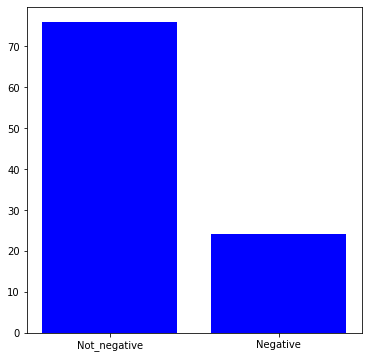

In [893]:
#obtain the model's predictions (logits)
mlp.run(sentence_3)
calc_preds = tf.nn.sigmoid(mlp.layer_1.dot(mlp.weights_1_2)).numpy()
not_negative_pred_mlp = float(calc_preds[0])*100

negative_pred_mlp = 100 - not_negative_pred_mlp

percentage_pred_mlp = []
percentage_pred_mlp.append(not_negative_pred_mlp)
percentage_pred_mlp.append(negative_pred_mlp)

plt.figure(figsize=(6,6))
plt.bar(x=[1,2], height=percentage_pred_mlp, color='Blue', tick_label=['Not_negative','Negative']);

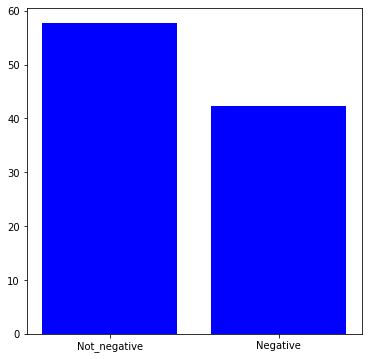

In [894]:
#obtain the model's predictions (logits)
mlp.run(sentence_4)
calc_preds = tf.nn.sigmoid(mlp.layer_1.dot(mlp.weights_1_2)).numpy()
not_negative_pred_mlp = float(calc_preds[0])*100

negative_pred_mlp = 100 - not_negative_pred_mlp

percentage_pred_mlp = []
percentage_pred_mlp.append(not_negative_pred_mlp)
percentage_pred_mlp.append(negative_pred_mlp)

plt.figure(figsize=(6,6))
plt.bar(x=[1,2], height=percentage_pred_mlp, color='Blue', tick_label=['Not_negative','Negative']);

### Visualizing words

In [574]:
#define a function to get the most similar words based on our trained model by a simple dot product of words index
# and input to hidden layer weights

def get_most_similar_words(focus = 'waste'):
    most_similar = Counter()
    
    for word in mlp.word2index.keys():
        most_similar[word] = np.dot(mlp.weights_0_1[mlp.word2index[word]],mlp.weights_0_1[mlp.word2index[focus]])
    return most_similar.most_common() 

In [575]:
get_most_similar_words('poor')[:20]

[('junk', 0.7499200186306263),
 ('waste', 0.7162073105972617),
 ('terrible', 0.6629453863437472),
 ('worst', 0.6576739923908752),
 ('useless', 0.6258631272274322),
 ('awful', 0.6114830999962172),
 ('garbage', 0.6103794211704523),
 ('poor', 0.6073895004346117),
 ('returning', 0.6056259799868808),
 ('refund', 0.603113117203415),
 ('horrible', 0.5932676928855177),
 ('worthless', 0.5922745278910917),
 ('return', 0.5742129394778503),
 ('returned', 0.5527564524365987),
 ('crap', 0.5343667267039877),
 ('stopped', 0.5239463821180084),
 ('disappointing', 0.4981961727241061),
 ('worse', 0.4929213865067056),
 ('poorly', 0.48948077220453745),
 ('trash', 0.4866923221122078)]

In [576]:
get_most_similar_words('awesome')[:20]

[('excellent', 0.6203482453353355),
 ('awesome', 0.5474506540693246),
 ('amazing', 0.5387222550864891),
 ('love', 0.5244652821698277),
 ('complaint', 0.4830966732288272),
 ('loves', 0.48018568290357067),
 ('great', 0.47102014331182307),
 ('perfect', 0.4618313216944407),
 ('complaints', 0.45436849034781013),
 ('satisfied', 0.4352524208328906),
 ('perfectly', 0.4130611541972979),
 ('fantastic', 0.4103239201652973),
 ('job', 0.4048090076559909),
 ('beat', 0.3982998531008033),
 ('best', 0.39178423561215914),
 ('good', 0.38539134511425205),
 ('stars', 0.38454442965294566),
 ('pleased', 0.38308835768475513),
 ('exactly', 0.37894656983836295),
 ('highly', 0.3716171281194599)]

In [812]:
#choose 500 words of not negative words and 500 of negative words to visualize

words_to_visualize = list()
for word, ratio in pos_neg_ratios.most_common(500):
    if(word in mlp.word2index.keys()):
        words_to_visualize.append(word)
        
for word, ratio in list(reversed(pos_neg_ratios.most_common()))[0:500]:
    if(word in mlp.word2index.keys()):
        words_to_visualize.append(word)

In [813]:
#creating colors base on positivity or negativity of words 
#create word vectors to to feed in to TSNE vector space

not_neg = 0
neg = 0

colors_list = []
vectors_list = []
for word in words_to_visualize:
    if word in pos_neg_ratios.keys():
        vectors_list.append(mlp.weights_0_1[mlp.word2index[word]])
        if (pos_neg_ratios[word] > 0):
            not_neg += 1
            colors_list.append("#00ff00") #showing not_negative words with green
        else:
            neg += 1
            colors_list.append("#000000") #showing not_negative words with black

In [814]:
#showing all the words in 2 dimentional way
tsne = TSNE(n_components=2, random_state=52)
words_tsne = tsne.fit_transform(vectors_list)

In [816]:
p = figure(tools='pan,wheel_zoom,reset,save',
          toolbar_location='above',
          title = 'vector T-SNE for most polarized words')

source = ColumnDataSource(data=dict(x1=words_tsne[:,0],
                                   x2=words_tsne[:,1],
                                   names=words_to_visualize,
                                   color=colors_list))
p.scatter(x='x1', y='x2', size=8, source=source, color='color')

word_labels = LabelSet(x='x1', y='x2', text='names', y_offset=6,
                      text_font_size='8pt', text_color='#555555',
                      source=source, text_align='center')
# p.add_layout(word_labels)
show(p)
# green indicates not negative words, black indicates negative words

## RNN by using LSTM and word Embeding

### Preprocessing Data

In [585]:
data = df5['clean_review'].map(word_tokenize).values
data

array([list(['not', 'the', 'right', 'size']),
       list(['they', 'come', 'in', 'a', 'blister', 'pack', 'of', 'batteries', 'the', 'use', 'by', 'dates', 'are', 'all', 'ok', 'no', 'out', 'of', 'date', 'batteries', 'received', 'br', 'br', 'i', 've', 'used', 'these', 'in', 'items', 'so', 'far', 'for', 'the', 'last', 'months', 'and', 'had', 'no', 'issues', 'whatsoever', 'br', 'br', 'cheap', 'price', 'and', 'fast', 'shipping']),
       list(['never', 'again', 'hard', 'too', 'set', 'up']), ...,
       list(['stopped', 'working', 'all', 'together', 'after', 'about', 'days', 'i', 'assume', 'it', 'was', 'from', 'sweat', 'but', 'i', 'couldn', 't', 'get', 'it', 'to', 'power', 'on', 'after', 'months', 'of', 'heavy', 'use', 'i', 'guess', 'it', 's', 'worth', 'but', 'not', 'much', 'more']),
       list(['horrible', 'batteries', 'dont', 'hold', 'a', 'charge', 'constantly', 'changing', 'batteries', 'wouldent', 'recommend', 'these', 'to', 'anyone']),
       list(['these', 'were', 'the', 'worst', 'earpho

In [600]:
#list of all the unique words in all reviews
vocab = sorted(total_counts, key=total_counts.get, reverse=True) #sorted from high frequency words to low

In [605]:
#because I want to use 0 padding for my reviews I wanted the index to start from 1
vocab_to_int = {word:idx for idx,word in enumerate(vocab, 1)}

In [617]:
df6 = df5.copy()

In [618]:
def data_to_int(x):
    return [vocab_to_int[word] for word in x.split()]

In [619]:
#Engineered a new column to include each review in integers
df6['data_to_int'] = df6['clean_review'].map(lambda x: data_to_int(x))

In [621]:
#reviews with not negative emotions labeled as 1 and the negative review emotions labeled as 0 
def labeling(row):
    if row.emotion == 'Not Negative':
        return 1
    else:
        return 0    

In [627]:
df6['label'] = df6.apply(lambda row: labeling(row), axis=1)

In [628]:
df6.drop(columns=['star_rating', 'review_body'], axis=1, inplace=True)

In [727]:
df6.head()

,emotion,clean_review,data_to_int,label
0,Negative,not the right size,"[16, 1, 139, 253]",0
1,Not Negative,they come in a blister pack of batteries the u...,"[24, 246, 13, 6, 7381, 934, 9, 185, 1, 49, 106...",1
2,Negative,never again hard too set up,"[183, 144, 251, 98, 120, 50]",0
3,Negative,i bought two units and place them side by side...,"[2, 78, 109, 790, 5, 369, 36, 242, 106, 242, 3...",0
4,Not Negative,this cable is exactly what i needed they are c...,"[11, 69, 7, 437, 67, 2, 236, 24, 26, 168, 17, ...",1


In [630]:
review_lengths = Counter([len(x) for x in df6.data_to_int])

In [640]:
#number of reviews with no length (zero-length), which are gonna be problematic in the near future!!!
print('Zero-Length Reviews: {}'.format(review_lengths[0]))  

Zero-Length Reviews: 203


In [664]:
#remove all the rows with zero-length reviews
df6.drop(df6[df6['data_to_int'].map(len) == 0].index, inplace=True)

In [641]:
#as we can see we have a review as long as 7358 words!
print('Maximum Reviews Length: {}'.format(max(review_lengths)))

Maximum Reviews Length: 7358


In [745]:
reviews_less_than_100 = []
reviews_more_than_100 = []
for tupled in review_lengths.most_common():
    if (tupled[0] < 101):
        reviews_less_than_100.append(tupled[1])
    else:
        reviews_more_than_100.append(tupled[1])

In [792]:
#as we can see almost 84% of our data belongs to reviews with less than 100 words
print('Number of reviews with length of less than 100 words: {}'.format(sum(reviews_less_than_100)))

Number of reviews with length of less than 100 words: 839906


In [793]:
#as we can see almost 17% of our data belongs to reviews with more than 100 words
print('Number of reviews with length of more than 100 words: {}'.format(sum(reviews_more_than_100)))

Number of reviews with length of more than 100 words: 173070


In [749]:
seq_len = 100
#initialize an array of all zeros
#There is one row for each review and each review is gonna be 100 sequence steps (seq_len) long 
features = np.zeros((len(df6), seq_len), dtype=int)

for i, row in enumerate(df6.data_to_int):
    features[i, -len(row):] = np.array(row)[:seq_len]

* After I grab each review and associate its index to it by using enumerate


* in the left side of equation above I am grabing row(i) and the number of columns from the end (-len(row):) in features variable; It is helpful for reviews with less than 100 words length, and it helps us to do the padding as well


* And on the right side besides i'm turning it to an array, I am also just considering the first 100 words of each review (we are processing only the first 200 words of each review)


In [751]:
#As an example: we are looking at the first 2 rows and the last 50 columns (from 50 to 100)
features[:2,50:100]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   16,    1,  139,  253],
       [   0,    0,    0,   24,  246,   13,    6, 7381,  934,    9,  185,
           1,   49,  106, 7529,   26,   45,  239,   51,   41,    9, 1243,
         185,  229,   14,   14,    2,  115,  105,   30,   13,  805,   27,
         204,    8,    1,  203,  162,    5,   43,   51,  381, 2044,   14,
          14,  168,   73,    5,  486,  377]])

In [752]:
#turn the labels to numpy array to increase speed and consistency in our data format
labels = np.array(df6.label)

### Train Test Split

In [753]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(features,labels,test_size=0.20, random_state= 52)

In [754]:
#split our data to have 10% for test and 10% for validation
X_test2, X_val2, y_test2, y_val2 = train_test_split(X_test1, y_test1, test_size=0.5, random_state=52)

In [755]:
print("\t\t\tFeature Shapes:")
print("Train Set: \t\t{}".format(X_train1.shape),
     "\nValidation set: \t{}".format(X_val2.shape),
     "\nTest Set: \t\t{}".format(X_test2.shape))

			Feature Shapes:
Train Set: 		(810218, 100) 
Validation set: 	(101278, 100) 
Test Set: 		(101277, 100)


### First Model

In [756]:
n_words =len(vocab)

In [703]:
lstm_size = 256
lstm_layers = 1
batch_size = 500
learning_rate = 0.001

In [736]:
model = Sequential()

In [737]:
embedding_size = 300
model.add(Embedding(n_words+1, embedding_size))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [738]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [743]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         42743700  
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 256)         570368    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           257       
Total params: 43,314,325
Trainable params: 43,314,325
Non-trainable params: 0
_________________________________________________________________


In [741]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=3,verbose=0,mode="auto",
                                                  restore_best_weights=True)

In [740]:
#trained base on validation accuracy for early stopping
model.fit(X_train1, y_train1, epochs=20,callbacks=[early_stopping], batch_size=1000, validation_data=(X_val2, y_val2))

Epoch 1/20
811/811 [==============================] - 4888s 6s/step - loss: 0.6449 - accuracy: 0.6213 - val_loss: 0.6200 - val_accuracy: 0.6400
Epoch 2/20
811/811 [==============================] - 4700s 6s/step - loss: 0.6153 - accuracy: 0.6444 - val_loss: 0.6185 - val_accuracy: 0.6418
Epoch 3/20
811/811 [==============================] - 4736s 6s/step - loss: 0.6066 - accuracy: 0.6492 - val_loss: 0.6154 - val_accuracy: 0.6444
Epoch 4/20
811/811 [==============================] - 4676s 6s/step - loss: 0.5992 - accuracy: 0.6530 - val_loss: 0.6175 - val_accuracy: 0.6444
Epoch 5/20
811/811 [==============================] - 4812s 6s/step - loss: 0.5914 - accuracy: 0.6568 - val_loss: 0.6234 - val_accuracy: 0.6433
Epoch 6/20
811/811 [==============================] - 4726s 6s/step - loss: 0.5850 - accuracy: 0.6604 - val_loss: 0.6319 - val_accuracy: 0.6434


In [742]:
#trained base on validation loss for early stopping
model.fit(X_train1, y_train1, epochs=20,callbacks=[early_stopping], batch_size=1000, validation_data=(X_val2, y_val2))

Epoch 1/20
811/811 [==============================] - 4692s 6s/step - loss: 0.5988 - accuracy: 0.6532 - val_loss: 0.6150 - val_accuracy: 0.6436
Epoch 2/20
811/811 [==============================] - 4727s 6s/step - loss: 0.5932 - accuracy: 0.6561 - val_loss: 0.6201 - val_accuracy: 0.6437
Epoch 3/20
811/811 [==============================] - 4640s 6s/step - loss: 0.5882 - accuracy: 0.6584 - val_loss: 0.6282 - val_accuracy: 0.6425
Epoch 4/20
811/811 [==============================] - 4628s 6s/step - loss: 0.5817 - accuracy: 0.6616 - val_loss: 0.6320 - val_accuracy: 0.6418


In [896]:
model.save('Models/model.h5')
model.save_weights('Models/model_w.h5')

### Second Model

In [744]:
model2 = Sequential()

In [757]:
embedding_size = 128
model2.add(Embedding(n_words+1, embedding_size))
model2.add(LSTM(256, return_sequences=True))
model2.add(GlobalMaxPool1D())
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

In [761]:
model2.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [762]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         18237312  
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 256)         394240    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 18,631,809
Trainable params: 18,631,809
Non-trainable params: 0
_________________________________________________________________


In [763]:
model2.fit(X_train1, y_train1, epochs=20,callbacks=[early_stopping],
           batch_size=1000, validation_data=(X_val2, y_val2))

Epoch 1/20
811/811 [==============================] - 1796s 2s/step - loss: 0.4342 - accuracy: 0.7898 - val_loss: 0.3225 - val_accuracy: 0.8596
Epoch 2/20
811/811 [==============================] - 1790s 2s/step - loss: 0.3065 - accuracy: 0.8679 - val_loss: 0.3142 - val_accuracy: 0.8629
Epoch 3/20
811/811 [==============================] - 1843s 2s/step - loss: 0.2819 - accuracy: 0.8797 - val_loss: 0.3055 - val_accuracy: 0.8671
Epoch 4/20
811/811 [==============================] - 1780s 2s/step - loss: 0.2606 - accuracy: 0.8904 - val_loss: 0.3070 - val_accuracy: 0.8673
Epoch 5/20
811/811 [==============================] - 1796s 2s/step - loss: 0.2402 - accuracy: 0.9008 - val_loss: 0.3181 - val_accuracy: 0.8652
Epoch 6/20
811/811 [==============================] - 1847s 2s/step - loss: 0.2207 - accuracy: 0.9093 - val_loss: 0.3326 - val_accuracy: 0.8636


In [897]:
model2.save('Models/model2.h5')
model2.save_weights('Models/model2_w.h5')

In [773]:
y_pred = model2.predict(X_test2)

In [774]:
y_pred[:5]

array([[0.17837316],
       [0.03145787],
       [0.96334577],
       [0.13003096],
       [0.97935295]], dtype=float32)

In [775]:
y_pred1 = np.where(y_pred > 0.49, 1, 0)

In [776]:
y_pred1[:5]

array([[0],
       [0],
       [1],
       [0],
       [1]])

In [779]:
clf_report = classification_report(y_test2,y_pred1)
print(clf_report)

              precision    recall  f1-score   support

           0       0.85      0.83      0.84     41710
           1       0.88      0.90      0.89     59567

    accuracy                           0.87    101277
   macro avg       0.86      0.86      0.86    101277
weighted avg       0.87      0.87      0.87    101277



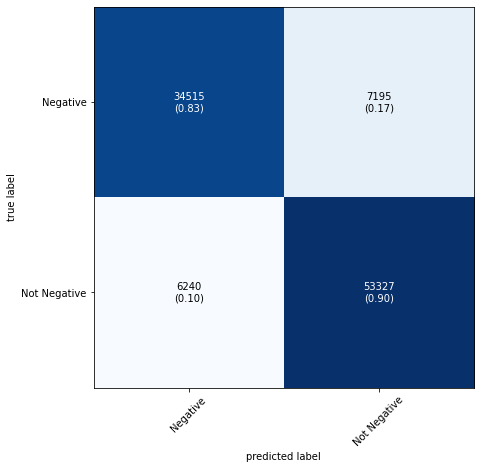

In [780]:
cm = confusion_matrix(y_test2,y_pred1)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ['Negative', 'Not Negative'],
                     show_normed=True);

### Testing a Review

In [820]:
# Define a function to get the sentiment of a sentence and the probability of that particular sentence
def get_sentiment(review):
    voc_to_int = []
    for word in review.split(" "):
        voc_to_int.append(vocab_to_int[word])
    feature = np.zeros((1, 100), dtype=int)
    feature[0, -len(voc_to_int):] = np.array(voc_to_int)[:100]
    
    y_pred = model2.predict(feature)
    y_pred1 = np.where(y_pred > 0.49, 1, 0)
    if y_pred1 == 1:
        out = 'Not Negative'
    else:
        out = 'Negative'
    
    return out , y_pred    

In [886]:
# Some examples to test the model
sentence_1 = 'this is not a good product'
sentence_2 = 'this is a good product'

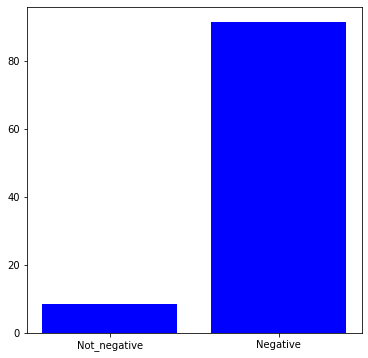

In [887]:
feel , percentage = get_sentiment(sentence_1)
not_negative_pred = float(percentage[0])*100

negative_pred = 100 - not_negative_pred

percentage_pred = []
percentage_pred.append(not_negative_pred)
percentage_pred.append(negative_pred)

plt.figure(figsize=(6,6))
plt.bar(x=[1,2], height=percentage_pred, color='Blue', tick_label=['Not_negative','Negative']);

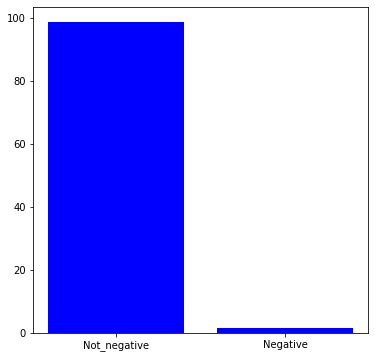

In [888]:
feel , percentage = get_sentiment(sentence_2)
not_negative_pred = float(percentage[0])*100

negative_pred = 100 - not_negative_pred

percentage_pred = []
percentage_pred.append(not_negative_pred)
percentage_pred.append(negative_pred)

plt.figure(figsize=(6,6))
plt.bar(x=[1,2], height=percentage_pred, color='Blue', tick_label=['Not_negative','Negative']);